## Micro Domain

The micro domain is defined by a bounding box and a smooth function parameterising the floor of the micro domain. 

In [13]:
import sys
sys.path.append('/home/emastr/phd/')

import numpy as np
import torch as pt
import torch.autograd as agrad
import matplotlib.pyplot as plt
from util.plot_tools import *
from boundary_solvers.blobs import *
from boundary_solvers.geometry import *
from scipy.sparse.linalg import gmres, LinearOperator
from operators.stokes_operator import StokesAdjointBoundaryOp
from util.unet import *
import torch.nn as nn

## Create data loader

Load and transform the data. 

In [14]:
def unpack_data(data):
    xlabels = ['x', 'y', 'dx', 'dy', 'ddx', 'ddy', 'vx', 'vy', 'w', 't']
    ylabels = ['rx', 'ry']
    inp = {xlabels[i]: data['X'][:, i, :] for i in range(10)}
    out = {ylabels[i]: data['Y'][:, i, :] for i in range(2)}
    return (inp, out)

def unpack(transform):
    """Decorator for if a method is supposed to act on the values of a dict."""
    def up_transform(data, *args, **kwargs):
        if type(data) == dict:
            return {k: transform(data[k], *args, **kwargs) for k in data.keys()}
        else:
            return transform(data, *args, **kwargs)
    return up_transform

@unpack
def subsample(x, idx):
    return x[idx]

@unpack
def integrate(x, w):
    return torch.cumsum(x * w, axis=len(x.shape)-1)

def subdict(dic, keys):
    return {k: dic[k] for k in keys if k in dic.keys()}

def concat_dict_entries(data):
    return torch.cat(tuple((d[:, None, :] for d in data.values())), dim=1)
    
def arclength(dx, dy, w):
    return integrate((dx**2 + dy**2)**0.5, w)    

def normalize(dx, dy):
    """Normalize 2-dim vector"""
    mag = (dx**2 + dy**2)**0.5
    return dx/mag, dy/mag
    
def curvature(dx, dy, ddx, ddy):
    """Find curvature of line segment given points"""
    mag = (dx**2 + dy**2)**0.5
    return (dx * ddy - dy * ddx) / (mag ** 3)

def invariant_quantities(inp):
    labels = ('tx', 'ty', 'c')
    tx, ty = normalize(inp['dx'], inp['dy'])
    c = curvature(inp['dx'], inp['dy'], inp['ddx'], inp['ddy'])
    data = (tx, ty, c)
    return {labels[i]: data[i] for i in range(len(data))}

Next, we need a way to create the integral operator from a data batch.

In [15]:
def op_factory(inp):
    Z   = inp['x']   + 1j * inp['y']
    dZ  = inp['dx']  + 1j * inp['dy']
    ddZ = inp['ddx'] + 1j * inp['ddy']
    W = inp['w']
    a = torch.ones(Z.shape[0],) * 0.5 * 1j
    return StokesAdjointBoundaryOp(Z, dZ, ddZ, W, a)

Create unrolled architecture

In [4]:
settings = {"in_channels":2, 
            "min_out_channels":4,
            "out_channels":2,
            "depth":3, 
            "batch_norm":2, 
            "width":2,
            "kernel_size":3,
            "padding":1,
            "padding_mode":'circular',
            "activation":nn.ReLU}

class Unrolled(nn.Module):
    
    def __init__(self, n_iter, net_factory, net_args=None, device="cpu", debug=False):
        super(Unrolled, self).__init__()
        
        self.debug = debug
        self.device = device
        self.n_iter = n_iter
        if net_args is None:
            self.nets = nn.ModuleList([net_factory() for i in range(n_iter)])
        else:
            self.nets = nn.ModuleList([net_factory(net_args[i]) for i in range(n_iter)])
        self.nets.to(device)
        
    def printmsg(self, msg):
        if self.debug:
            print(msg)
        else:
            pass
        
            
    def forward(self, x: dict, subset=None, op=None, truncate=None) -> torch.Tensor:
        """
        param x: tuple (x, y) with x = (N,4,K) and y = (N, C, K) 
        where x = [z, dz, ddz, w, p0] (boundary data + initial data)
        and y = input data to feed the network together with the gradient of the residual.
        """
        # If input is 5-dimensional, treat as raw problem data
        if op is None:
            self.printmsg("Making operator...")
            op = op_factory(x)
        
        if truncate is None:
            truncate = self.n_iter
        
        # Extract riesz vector components to use as starting point
        
        self.printmsg("concatting..")
        v = concat_dict_entries(subdict(x, {'vx', 'vy'}))
        
        self.printmsg("Cloning...")
        y = v.clone()
        
        ##### CURRENTLY NOT USED
        # Extract subset to input alongside Kx - v0
        if subset is not None:
            self.printmsg("Subsetting")
            x = subdict(x, subset)

        ##### TODO: MAKE USE OF THESE QUANTITIES?
        self.printmsg("Entering fwd loop")
        for i in range(truncate):
            self.printmsg(f"Shape: {y.shape}")
            y = y + self.nets[i](op(y)-v)
                
        return y
    
    
def factory():
    #return Unet(**settings)
    return nn.Sequential(nn.Conv1d(2,2,3,padding=1, padding_mode='circular'),\
                         nn.ReLU(),\
                         nn.Conv1d(2,2,3,padding=1, padding_mode='circular'))

@unpack
def to_dtype(x, dtype):
    return x.to(dtype)

In [5]:
# Load and transform
data = torch.load(f"/home/emastr/phd/data/problem_data_riesz_TEST.torch")
inp, out = unpack_data(data)

dtype = torch.double
inp, out = to_dtype(inp, dtype), to_dtype(out, dtype)

# Add invariant quantities to data.
#inp.update(invariant_quantities(inp))

# Normalise curvature using monotone function sigmoid(x/2) - 1/2.
#inp['c'] = 1/(1 + torch.exp(-0.5 * inp['c'])) - 0.5 

Split into training and test data

In [6]:
## TRAINING DATA
M_train = 200#0
M_batch = 5 # Batch
idx_train = list(range(M_train))
X_train = subsample(inp, idx_train)
Y_train = concat_dict_entries(subsample(out, idx_train))
op_train = op_factory(X_train)
#X_train = subdict(X_train, {'vx', 'vy'})

## TEST DATA
M_test = 100#0
idx_test = list(range(M_train, M_test + M_train))
X_test = subsample(inp, idx_test)
Y_test = concat_dict_entries(subsample(out, idx_test))
op_test = op_factory(X_test)
#X_test = subdict(X_test, {'vx', 'vy'})

Create network

In [7]:
n_layers = 12
net = Unrolled(n_layers, factory, None)
net.debug = False

Do training

In [8]:
# Predefine list of losses 
trainloss = []
testloss  = []

In [9]:
# Loss function
loss_fcn  = nn.MSELoss()
V_test = concat_dict_entries(subdict(X_test, {'vx', 'vy'}))
benchloss = loss_fcn(V_test, Y_test).item()
optim     = torch.optim.Adam(net.parameters())

# DO TRAINING LOOP 
##################################################
N = 30001 #30001

info = {"epochs": N, "batch": M_batch, "truncate": True}

for i in range(N):
    idx_batch = torch.randperm(M_train)[:M_batch] 
    Y_batch   = Y_train[idx_batch]
    X_batch   = subsample(X_train, idx_batch)
    op_batch = lambda x: op_train(x, idx=idx_batch)
    
    # Train on truncated net that expands as iterations progress
    truncate=min(int(np.ceil(n_layers * (i+1)/(N+1) * 2)), n_layers)
    Y_net_batch = net(X_batch, op=op_batch, truncate=truncate)
    loss = loss_fcn(Y_net_batch, Y_batch)
    loss.backward()
    optim.step()
        
    trainloss.append(loss.item())
    testloss.append(loss_fcn(net(X_test, op=op_test, truncate=truncate), Y_test).item())
        
    optim.zero_grad()
        
    print(f"Step {i}, Using {truncate}/{n_layers} layers. Train loss = {trainloss[-1]}, test loss = {testloss[-1]}, benchmark={benchloss}", end="\r")
    
    if i % 1000 == 0:
        torch.save({"state dict" : net.state_dict(), 
                    "settings"   : settings,
                    "trainloss"  : trainloss,
                    "testloss"   : testloss}, 
                    f"/home/emastr/phd/data/unrolled_adjoint_state_dict_2022_12_02_12lay_cnn_recurse_{i}.Torch") # old namme unet_state_dict #Kernel size 5, stride 2

In [10]:
save = torch.load(f"/home/emastr/phd/data/unrolled_adjoint_state_dict_2022_12_02_12lay_cnn_recurse_30000.Torch")
trainloss = save["trainloss"]
testloss = save["testloss"]
net.load_state_dict(save["state dict"])

<All keys matched successfully>

In [11]:
from scipy.fft import fft

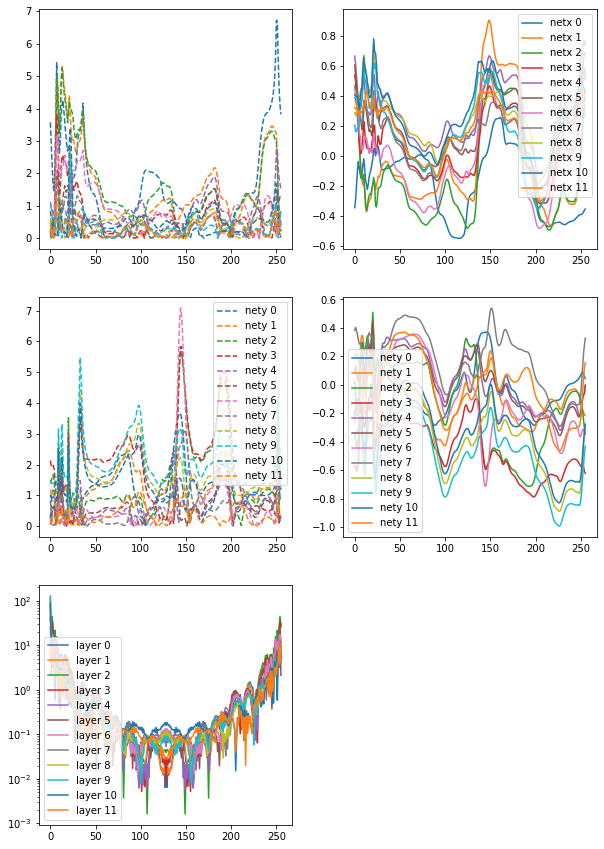

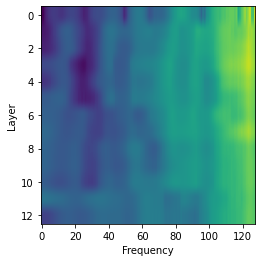

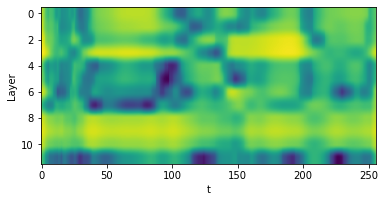

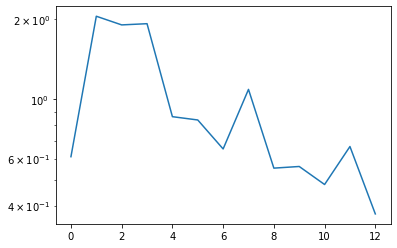

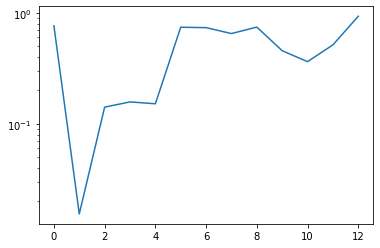

In [12]:
Y_net = net(X_test, op=op_test)
v = op_test(Y_test)# + Y_test
Y_net = Y_net.detach()
i=99

vx = X_test['vx'][i, :]
vy = X_test['vy'][i, :]

oyx = v[i, 0, :]
oyy = v[i, 1, :]

yx = Y_test[i, 0, :]
yy = Y_test[i, 1, :]

ynx = Y_net[i, 0, :]
yny = Y_net[i, 1, :]


inp = concat_dict_entries(subdict(X_test,{'vx', 'vy'}))
out = inp.clone()

def smooth(f, N):
    return np.convolve(f, np.ones(N)/N, 'same')

err = [np.linalg.norm(np.abs(yx - vx)/(np.abs(yx - vx)+1e-1))/len(vx)**0.5]
err_align = [np.dot(vy.numpy(), yy.numpy()) / np.linalg.norm(yy.numpy())/np.linalg.norm(vy.numpy())]

fft_err_mat = np.log(np.abs(fft((yy - vy).numpy())))
err_mat = np.log(np.abs(yy-vy).numpy())

plt.figure(figsize=(10,15))
for j in range(len(net.nets)):
    out = out + net.nets[j](op_test(out) - inp)
    ynet = out[i].detach().numpy()
    ynetx = ynet[0, :] #smooth(ynet[0, :], 10)
    ynety = ynet[1, :]#smooth(ynet[1, :], 10)
    if True:#j%2 == 1:
        plt.subplot(321)
        ax = np.abs(yx - ynetx)/(np.abs(yx - vx)+1e-1)
        plt.plot(ax, '--', label=f'netx {j}')#, alpha=0.5)
        
        plt.subplot(322)
        plt.plot(ynetx, label=f'netx {j}')#, alpha=0.5)
        plt.legend()
        
        plt.subplot(323)
        ay = np.abs(yy - ynety)/(np.abs(yy - vy)+1e-1)
        plt.plot(ay, '--', label=f'nety {j}')#, alpha=0.5)
        plt.legend()
        
        plt.subplot(324)
        plt.plot(ynety,label=f'nety {j}')#, alpha=0.5)
        plt.legend()
        
        plt.subplot(325)
        fft_err = np.abs(fft(ynety-yy.numpy()))
        plt.semilogy(fft_err, label=f"layer {j}")
        fft_err_mat = np.vstack([fft_err_mat, smooth(np.log(fft_err), 10)])
        plt.legend()
        
        err_mat = np.vstack([err_mat, smooth(np.log(np.abs(ynety - yy.numpy())),10)])
        
        ### Relative error
        err.append(np.linalg.norm(ax) / len(ax)**0.5)
        err_align.append(np.dot(ynety, yy.numpy()) / np.linalg.norm(yy.numpy())/np.linalg.norm(ynety))
        
plt.figure()
plt.imshow(fft_err_mat[:, fft_err_mat.shape[1]//2:], aspect=10)
plt.xlabel("Frequency")
plt.ylabel("Layer")

plt.figure()
plt.imshow(err_mat[1:], aspect=10)
plt.xlabel("t")
plt.ylabel("Layer")

plt.figure()
plt.semilogy(err)
        
    
plt.figure()
plt.semilogy(err_align)
        

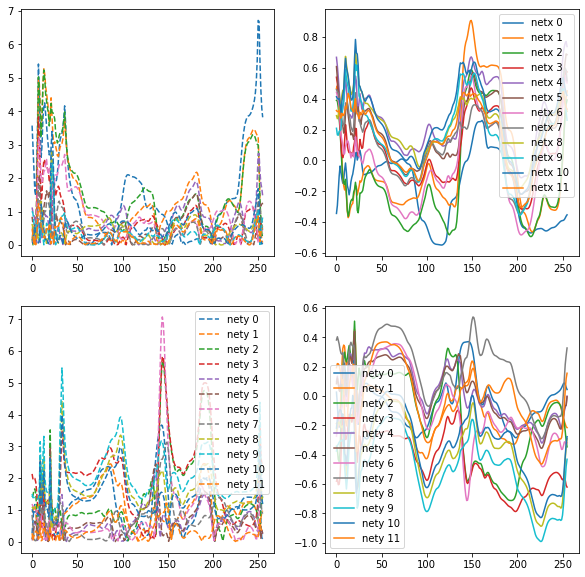

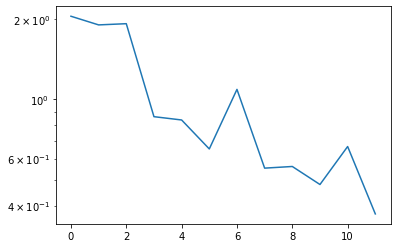

In [13]:
Y_net = net(X_test, op=op_test)
v = op_test(Y_test)# + Y_test
Y_net = Y_net.detach()
i=99

vx = X_test['vx'][i, :]
vy = X_test['vy'][i, :]

oyx = v[i, 0, :]
oyy = v[i, 1, :]

yx = Y_test[i, 0, :]
yy = Y_test[i, 1, :]

ynx = Y_net[i, 0, :]
yny = Y_net[i, 1, :]


inp = concat_dict_entries(subdict(X_test,{'vx', 'vy'}))
out = inp.clone()

def smooth(f, N):
    return np.convolve(f, np.ones(N)/N, 'same')

err = []
plt.figure(figsize=(10,10))
for j in range(len(net.nets)):
    out = out + net.nets[j](op_test(out) - inp)
    ynet = out[i].detach().numpy()
    ynetx = ynet[0, :] #smooth(ynet[0, :], 10)
    ynety = ynet[1, :]#smooth(ynet[1, :], 10)
    if True:#j%2 == 1:
        plt.subplot(221)
        ax = np.abs(yx - ynetx)/(np.abs(yx - vx)+1e-1)
        plt.plot(ax, '--', label=f'netx {j}')#, alpha=0.5)
        err.append(np.linalg.norm(ax) / len(ax)**0.5)
        
        plt.subplot(222)
        plt.plot(ynetx, label=f'netx {j}')#, alpha=0.5)
        plt.legend()
        
        plt.subplot(223)
        ay = np.abs(yy - ynety)/(np.abs(yy - vy)+1e-1)
        plt.plot(ay, '--', label=f'nety {j}')#, alpha=0.5)
        plt.legend()
        
        plt.subplot(224)
        plt.plot(ynety,label=f'nety {j}')#, alpha=0.5)
        plt.legend()
        

plt.figure()
plt.semilogy(err)
        

TypeError: new(): invalid data type 'str'

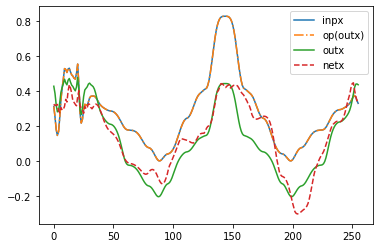

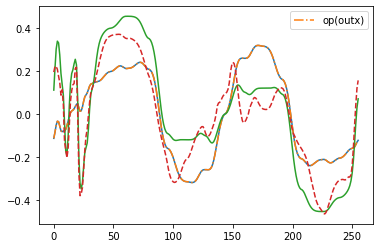

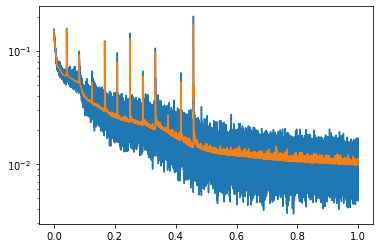

<Figure size 432x288 with 0 Axes>

In [14]:
Y_net = net(X_test, op=op_test)
v = op_test(Y_test)# + Y_test
Y_net = Y_net.detach()
i=99

vx = X_test['vx'][i, :]
vy = X_test['vy'][i, :]

oyx = v[i, 0, :]
oyy = v[i, 1, :]

yx = Y_test[i, 0, :]
yy = Y_test[i, 1, :]

ynx = Y_net[i, 0, :]
yny = Y_net[i, 1, :]

plt.figure(1)
plt.plot(vx, label='inpx')
plt.plot(oyx, '-.', label='op(outx)')
plt.plot(yx, label='outx')
plt.plot(ynx, '--', label="netx")
plt.legend()

plt.figure(2)
plt.plot(vy)
plt.plot(oyy, '-.', label='op(outx)')
plt.plot(yy)
plt.plot(yny, '--')
plt.legend()

inp = concat_dict_entries(subdict(X_test,{'vx', 'vy'}))
out = inp.clone()


plt.figure(3)
plt.semilogy(np.linspace(0,1,len(trainloss)), trainloss)
plt.semilogy(np.linspace(0,1,len(testloss)), testloss)

plt.figure(4)
plt.plot(inp['x'][0, :], inp['y'][0, :])
plt.quiver(inp['x'][0,:], inp['y'][0,:], inp['dy'][0,:], -inp['dx'][0,:])
plt.quiver(inp['x'][0,:], inp['y'][0,:], inp['ddx'][0,:], inp['ddy'][0,:], color='red')
plt.axis("equal")

In [ ]:
Y_net = net(X_test, op=op_test)
v = op_test(Y_test)# + Y_test
Y_net = Y_net.detach()
for i in [90]:
    plt.figure(1)
    plt.plot(X_test['vx'][i, :], label='inpx')
    plt.plot(v[i,0,:], '-.', label='op(outx)')
    plt.plot(Y_net[i, 0, :], label='netx')
    plt.plot(Y_test[i, 0, :], '--', label='outx')
    plt.legend()
    plt.figure(2)
    plt.plot(X_test['vy'][i, :])
    plt.plot(v[i,1,:], '-.', label='op(outx)')
    plt.plot(Y_net[i, 1, :])
    plt.plot(Y_test[i, 1, :])
    
plt.figure(3)
plt.semilogy(np.linspace(0,1,len(trainloss)), trainloss)
plt.semilogy(np.linspace(0,1,len(testloss)), testloss)

plt.figure(4)
plt.plot(inp['x'][0, :], inp['y'][0, :])
plt.quiver(inp['x'][0,:], inp['y'][0,:], inp['dy'][0,:], -inp['dx'][0,:])
plt.quiver(inp['x'][0,:], inp['y'][0,:], inp['ddx'][0,:], inp['ddy'][0,:], color='red')
plt.axis("equal")